Used Car Price Prediction

Author: Matheus D Silva

Date: October, 2025

This notebook walks through the process of building a linear regression model to predict the price of used cars. The project covers data cleaning, feature engineering, modeling, and evaluation based on a dataset from Kaggle.

In [8]:
# --- 1. Importing Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Data Loading and Initial Exploration

First, we'll load the dataset and perform an initial diagnosis to understand its structure, data types, and identify any immediate issues like missing values.



In [9]:
# Load the dataset
file_path = "used_cars.csv" # Make sure this file is in the same directory
df = pd.read_csv(file_path)

# Display the first 5 rows to get a feel for the data
print("First 5 rows of the dataset:")
display(df.head())

# Get a summary of the dataframe, including data types and non-null counts
print("\nInitial DataFrame information:")
df.info()

First 5 rows of the dataset:


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"



Initial DataFrame information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         4009 non-null   object
 1   model         4009 non-null   object
 2   model_year    4009 non-null   int64 
 3   milage        4009 non-null   object
 4   fuel_type     3839 non-null   object
 5   engine        4009 non-null   object
 6   transmission  4009 non-null   object
 7   ext_col       4009 non-null   object
 8   int_col       4009 non-null   object
 9   accident      3896 non-null   object
 10  clean_title   3413 non-null   object
 11  price         4009 non-null   object
dtypes: int64(1), object(11)
memory usage: 376.0+ KB


Data Preprocessing

This section handles all the necessary cleaning and preparation steps to get the data ready for modeling.

2.1. Data Cleaning and Type Conversion

The milage and price columns are loaded as text objects due to special characters. We need to convert them to numerical types.

In [10]:
# --- Data Cleaning and Type Conversion ---

# Clean and convert the 'milage' column from object to integer
# Steps: 1. Remove ' mi.' suffix -> 2. Remove commas -> 3. Convert to int
df['milage'] = (df['milage']
                .str.replace(' mi.', '', regex=False)
                .str.replace(',', '')
                .astype(int))

# Clean and convert the 'price' column from object to integer
# Steps: 1. Remove '$' prefix -> 2. Remove commas -> 3. Convert to int
df['price'] = (df['price']
               .str.replace('$', '', regex=False)
               .str.replace(',', '')
               .astype(int))

print("Data types after cleaning 'price' and 'milage' have been updated.")

Data types after cleaning 'price' and 'milage' have been updated.


2.2. Handling Missing and Non-Standard Values

We'll fill missing values in key categorical columns using the mode (the most frequent value). We'll also clean up some non-standard text entries.

In [11]:
# --- Missing Data Imputation and Cleanup ---

# Clean up non-standard text entries in 'fuel_type' before filling NaNs
non_standard_values = ['–', 'not supported']
fuel_mode = df['fuel_type'].mode()[0]
df['fuel_type'] = df['fuel_type'].replace(non_standard_values, fuel_mode)
print("Cleaned non-standard text from 'fuel_type'.")

# Define columns with missing values and fill them with their respective modes
columns_to_fill_with_mode = ['fuel_type', 'accident', 'clean_title']

for column in columns_to_fill_with_mode:
    mode_value = df[column].mode()[0]
    df[column] = df[column].fillna(mode_value)
    print(f"Filled missing values in '{column}' with mode: '{mode_value}'")

# Verify that all columns are now full
print("\nVerifying missing values after imputation:")
df.info()

Cleaned non-standard text from 'fuel_type'.
Filled missing values in 'fuel_type' with mode: 'Gasoline'
Filled missing values in 'accident' with mode: 'None reported'
Filled missing values in 'clean_title' with mode: 'Yes'

Verifying missing values after imputation:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         4009 non-null   object
 1   model         4009 non-null   object
 2   model_year    4009 non-null   int64 
 3   milage        4009 non-null   int64 
 4   fuel_type     4009 non-null   object
 5   engine        4009 non-null   object
 6   transmission  4009 non-null   object
 7   ext_col       4009 non-null   object
 8   int_col       4009 non-null   object
 9   accident      4009 non-null   object
 10  clean_title   4009 non-null   object
 11  price         4009 non-null   int64 
dtypes: int64(3), object(9)
memory usag

3. Feature Engineering

Now we'll transform our clean data into a format suitable for the machine learning model. This involves converting categorical text data into numerical format.

In [12]:
# --- Feature Engineering ---

# One-Hot Encode categorical variables with a manageable number of unique values.
# We use drop_first=True to avoid creating redundant columns (multicollinearity).
categorical_cols = ['brand', 'fuel_type', 'transmission', 'accident', 'clean_title']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)


# For this first model, we'll drop columns with too many unique text values (high cardinality).
# These could be engineered more carefully in a more advanced version of the project.
high_cardinality_cols = ['model', 'engine', 'ext_col', 'int_col']
df_model_ready = df_encoded.drop(columns=high_cardinality_cols)

print("Shape of the final DataFrame for modeling:", df_model_ready.shape)
print("Final features ready for modeling:")
display(df_model_ready.head())

Shape of the final DataFrame for modeling: (4009, 125)
Final features ready for modeling:


,model_year,milage,price,brand_Alfa,brand_Aston,brand_Audi,brand_BMW,brand_Bentley,brand_Bugatti,brand_Buick,...,transmission_M/T,transmission_Manual,"transmission_Manual, 6-Spd",transmission_SCHEDULED FOR OR IN PRODUCTION,transmission_Single-Speed Fixed Gear,transmission_Transmission Overdrive Switch,transmission_Transmission w/Dual Shift Mode,transmission_Variable,transmission_–,accident_None reported
0,2013,51000,10300,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021,34742,38005,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022,22372,54598,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2015,88900,15500,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2021,9835,34999,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


4. Modeling and Evaluation

With our data prepared, we can now build and evaluate our regression model. To make the process clean and repeatable, we'll define a function to handle the training and evaluation.

--- Baseline Model with Outliers Results ---
Root Mean Squared Error (RMSE): $137,938.23


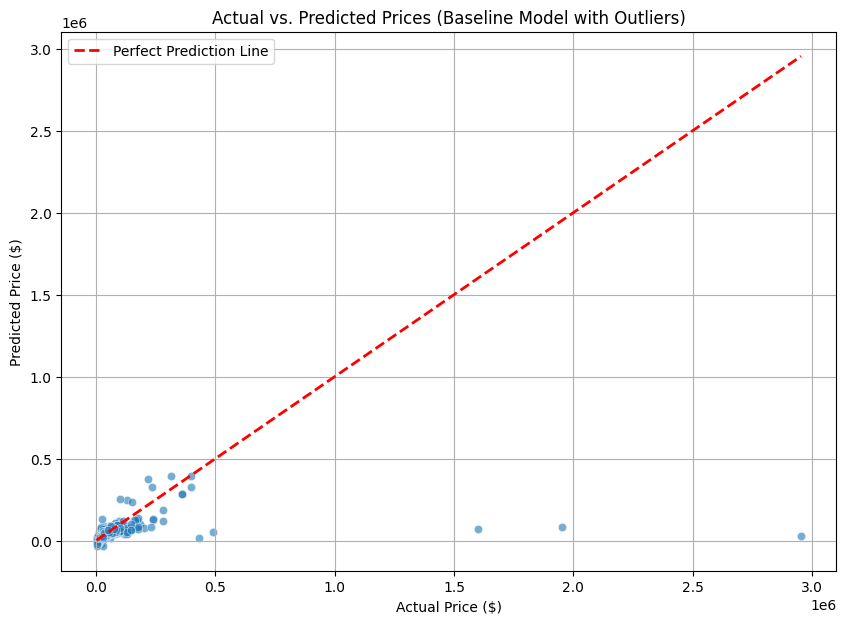

In [13]:
def train_and_evaluate_model(dataframe, model_name="Model"):
    """
    Splits data, trains a Linear Regression model, and evaluates its performance.
    
    Args:
        dataframe (pd.DataFrame): The preprocessed dataframe ready for modeling.
        model_name (str): A name for the model being evaluated (for printing).
        
    Returns:
        float: The Root Mean Squared Error (RMSE) of the model.
    """
    # 1. Separate Features (X) and Target (y)
    X = dataframe.drop('price', axis=1)
    y = dataframe['price']

    # 2. Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 3. Train the Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # 4. Make predictions and calculate error
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    
    print(f"--- {model_name} Results ---")
    print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")

    # 5. Plot Actual vs. Predicted values
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=y_test, y=predictions, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', lw=2, label='Perfect Prediction Line')
    plt.title(f'Actual vs. Predicted Prices ({model_name})')
    plt.xlabel('Actual Price ($)')
    plt.ylabel('Predicted Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return rmse

# --- Run the main model with all data ---
rmse_original = train_and_evaluate_model(df_model_ready, model_name="Baseline Model with Outliers")

5. Iteration: Improving the Model by Handling Outliers

Our first model's performance was heavily skewed by a few extremely expensive cars (outliers). Let's run an experiment where we remove these outliers and retrain the model to see if its performance on the majority of cars improves.

Original number of cars: 4009
Number of cars after removing those over $1,500,000: 4006
--- Model without Extreme Outliers Results ---
Root Mean Squared Error (RMSE): $28,772.17


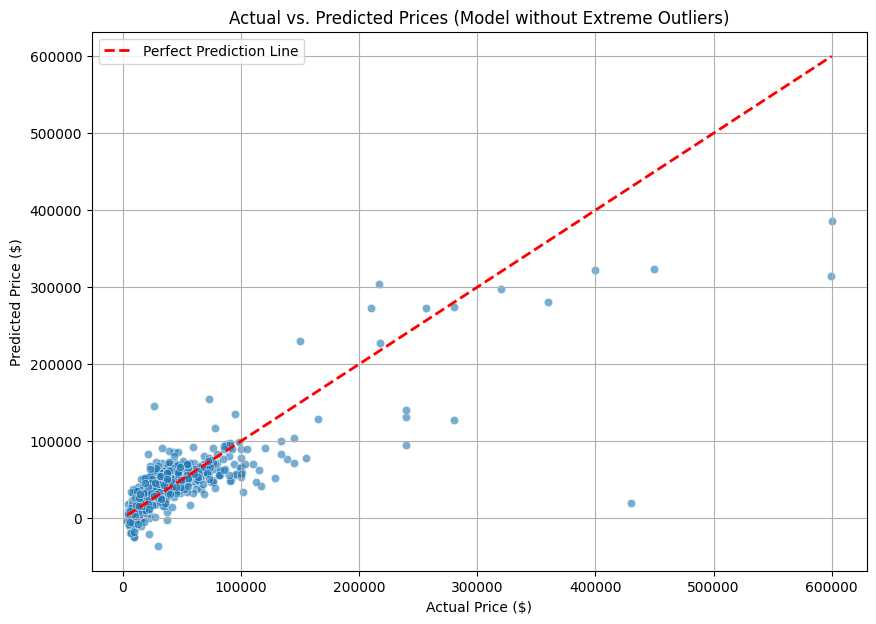


--- Model Comparison ---
Original RMSE: $137,938.23
RMSE after removing outliers: $28,772.17
Improvement in RMSE: $109,166.07


In [14]:
# Define a price limit to exclude extreme outliers
price_limit = 1_500_000

# Create a new DataFrame without the outliers
df_no_outliers = df_model_ready[df_model_ready['price'] < price_limit]

print(f"Original number of cars: {len(df_model_ready)}")
print(f"Number of cars after removing those over ${price_limit:,.0f}: {len(df_no_outliers)}")

# --- Run the model on the dataset without outliers ---
rmse_no_outliers = train_and_evaluate_model(df_no_outliers, model_name="Model without Extreme Outliers")

# --- Compare Results ---
print("\n--- Model Comparison ---")
print(f"Original RMSE: ${rmse_original:,.2f}")
print(f"RMSE after removing outliers: ${rmse_no_outliers:,.2f}")
improvement = rmse_original - rmse_no_outliers
print(f"Improvement in RMSE: ${improvement:,.2f}")

Conclusion

By cleaning the data, engineering relevant features, and training a linear regression model, we were able to create a baseline predictor for used car prices. Our analysis showed that the model's performance, as measured by RMSE, was significantly impacted by high-priced outliers.

After removing these outliers, the model's RMSE improved dramatically, indicating a much better fit for the majority of the cars in the dataset. This highlights the importance of understanding data distribution and performing iterative analysis to refine a model's performance. Future improvements could involve using more advanced models (like Random Forest) or engineering features from the high-cardinality text columns that were initially dropped.